# Topics in English Quran

In [120]:
%reset -f 
import glob
from collections import defaultdict
import pdb
import time
import re
import sys

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from gensim import corpora, models
# from gensim.utils import lemmatize  # not working with PY3.7 due to Pattern package
from wordcloud import WordCloud
import spacy
import pyLDAvis
import pyLDAvis.gensim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from QuranCorpus import QuranCorpus

%matplotlib inline
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 500)

## Download required data and models
# import nltk
# nltk.download('stopwords')
# %python -m spacy download en_core_web_sm

# Quran text downloaded at http://www.clearquran.com/
# Example for Arabic Quran - https://github.com/aelbuni/quran-nlp/tree/master/quran_nlp

# Pre-processing

In [129]:
additional_stops = None #['god', 'lord']
quran_corpus = QuranCorpus()
quran_corpus.read_in_quran()

### Read in and decode

In [123]:
df0 = pd.DataFrame({'text': quran_corpus.documents_by_verse, 'surah': quran_corpus.i_surah, 'verse': quran_corpus.i_verse})

In [124]:
df0.head()

,text,surah,verse
0,"praise be to allah, lord of the worlds.",1,2
1,"the most gracious, the most merciful.",1,3
2,master of the day of judgment.,1,4
3,"it is you we worship, and upon you we call for help.",1,5
4,guide us to the straight path.,1,6


#### Remove number, common words, urls

In [125]:
# reg_list = []
# reg_number = r'\d+'
# reg_kw = r'global warming|climate change|climate'
# reg_common_phrase = r'on twitter|https?:\/\/.*[\r\n]*'

# reg_list += [reg_number]
# reg_list += [reg_kw]
# reg_list += [reg_common_phrase] 

# pattern_string = '|'.join(reg_list)
# patt = re.compile(pattern_string)
# docs_raw = [patt.sub('', doc) for doc in docs_raw]

In [126]:
is_by_verse = True
tokens, processed, stem_map = quran_corpus.parse_docs(is_by_verse)

# Remove '-PRON', single letter
processed = [list(filter(lambda a: a != '-PRON-' and len(a) > 1, i)) for i in processed]
# A 1-1 stem to original word map, using the most frequent word
stem_map_by_count = {stemmed: max(originals, key=lambda i: originals[i]) for stemmed, originals in stem_map.items()}

#### Remove docs with specific words from analysis

In [127]:
# KW1 = ['need', 'help', 'signature', 'petition']
# KW2 = ['help', 'spare', 'minute']
# def filter_common_kw(x, kw):
#     return all(i in x for i in kw)
# def filter_common_docs(x):
#     return filter_common_kw(x, KW1) or filter_common_kw(x, KW2)

# top_docs = df[df.processed.apply(filter_common_docs)].copy()

## Some EDA

### Word freq

In [128]:
tokens_proc = tokens
df_word = pd.Series([jj for ii in tokens_proc for jj in ii])

df_word.value_counts()[:4]

allah    2411
lord      909
said      774
say       751
Name: count, dtype: int64

In [27]:
# df.to_csv('processed.csv', index=False)
# from ast import literal_eval
# df = pd.read_csv('processed.csv', converters={"processed": literal_eval})

In [28]:
# check some verses 
# count = 0
# for ii, jj in enumerate(tokens):    
#     if 'day' in jj:
#         count += 1
#         print(ii, docs[ii])
#         if count > 2:
#             break

### get ngram

In [29]:
num_grams = 3
ngrams_by_verse = [list(ngrams(token, num_grams)) for token in tokens_proc]

In [30]:
all_ngrams = []
ind_surah = []
ind_verse = []
for i, j in enumerate(ngrams_by_verse):
    for g in j:
        ind_surah.append(i_surah[i])
        ind_verse.append(i_verse[i])
        all_ngrams.append(g)

In [31]:
dfng = pd.DataFrame({'value': all_ngrams, 'surah': ind_surah, 'verse': ind_verse})

In [32]:
dfng_joined = pd.merge(dfng, df0, on=['surah', 'verse'])

In [44]:
# Most requent ngrams
num_grams_freq = dfng_joined['value'].value_counts()
num_grams_freq.head(5)

value
(allah, forgiving, merciful)    39
(lords, marvels, deny)          31
(beneath, rivers, flow)         30
(created, heavens, earth)       26
(gardens, beneath, rivers)      26
Name: count, dtype: int64

In [45]:
# related surahs
dfng_joined[dfng_joined['value'] == num_grams_freq.index[1]][:4]

,value,surah,verse,text
40058,"(lords, marvels, deny)",55,14,so which of your lords marvels will you deny?
40065,"(lords, marvels, deny)",55,17,so which of your lords marvels will you deny?
40070,"(lords, marvels, deny)",55,19,so which of your lords marvels will you deny?
40074,"(lords, marvels, deny)",55,22,so which of your lords marvels will you deny?


#### Chapter 55 - So which of the marvels of your Lord would you deny

In [50]:
dfng_joined[dfng_joined['value'] == num_grams_freq.index[1]]['surah'].value_counts()  # ('lords', 'marvels', 'deny')

surah
55    31
Name: count, dtype: int64

## Embedding and similarity 

In [79]:
tokens_proc = processed
import gensim.models as w2v
# Use one worker to ensure each run yields the same result
model = w2v.Word2Vec(sentences=tokens_proc, vector_size=128, window=17, min_count=20, sg=0, alpha=0.22, workers=-1, seed=42)
# model.save('./tokens_CBOW.model')
wv = model.wv

In [80]:
wv.most_similar("people", topn=5)

[('guardian', 0.2617100179195404),
 ('jinn', 0.2373923510313034),
 ('regard', 0.23266813158988953),
 ('unaware', 0.22631710767745972),
 ('ask', 0.22617341578006744)]

In [93]:
from sklearn.decomposition import PCA
words = [w for w in df_word.value_counts()[:200].index.values if w in wv]
X = np.array([wv[w] for w in words])

pca = PCA(n_components=10)
result = pca.fit_transform(X)


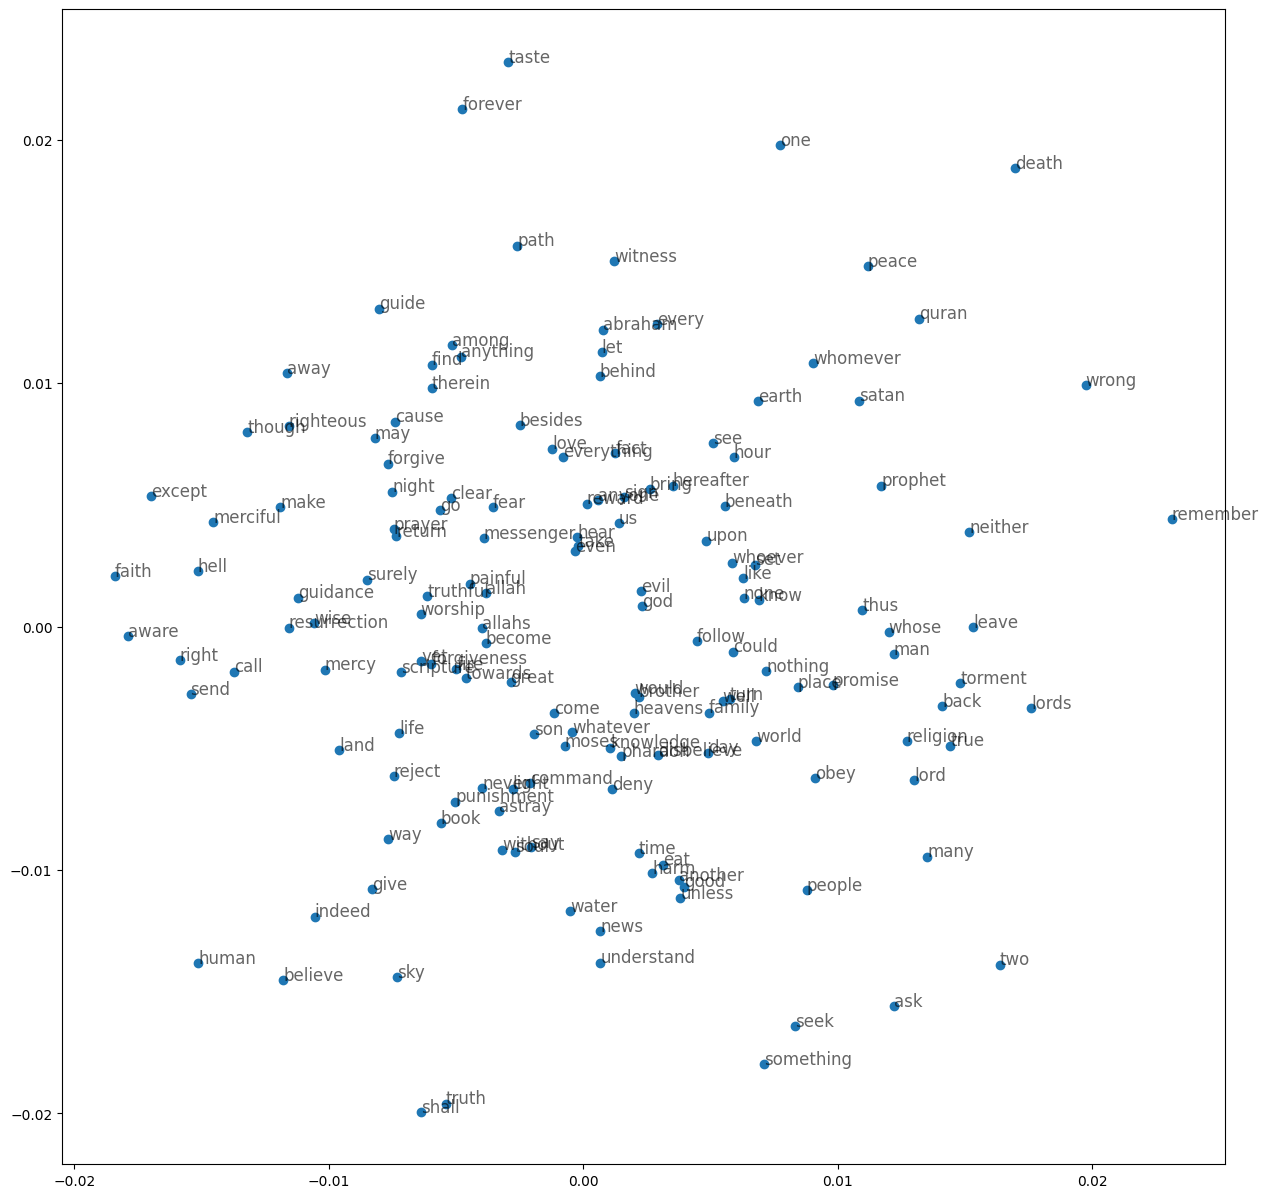

In [94]:
# create a scatter plot of the projection
f, a = plt.subplots(figsize=(15, 15))
a.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    a.annotate(word, xy=(result[i, 0], result[i, 1]), alpha=0.6, fontsize=12)
# a.set_xlim([0, 3]); a.set_ylim([0, 3])
plt.show()

## Topics

### Parse by surah

In [95]:
if is_by_verse:
    df0['processed'] = processed
    processed_by_surah = df0.groupby('surah')['processed'].apply(sum).values.tolist()
else: 
    processed_by_surah = processed

### Making dictionary and corpus

In [96]:
# making dictionary and corpus
dictionary = corpora.Dictionary(processed_by_surah)
corpus = [dictionary.doc2bow(text) for text in processed_by_surah]  # bag of words
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
# Save
#dictionary.save('/tmp/dict.dict')
#corpora.MmCorpus.serialize('/tmp/temp.mm', corpus)

### TFIDF

In [98]:
item_document_fre = dictionary.dfs
for k in dictionary.keys()[:4]:
    print(k, dictionary[k], item_document_fre[k])

0 allah 84
1 anger 4
2 bless 27
3 call 54


In [99]:
# Compare bow and tiidf
i = 0
print(processed_by_surah[i], '\n',
      [dictionary[k[0]] for k in corpus[i]], '\n',
      corpus[i], '\n', 
      corpus_tfidf[i])

['praise', 'allah', 'lord', 'worlds', 'gracious', 'merciful', 'master', 'day', 'judgment', 'worship', 'upon', 'call', 'help', 'guide', 'we', 'straight', 'path', 'path', 'bless', 'anger', 'misguide'] 
 ['allah', 'anger', 'bless', 'call', 'day', 'gracious', 'guide', 'help', 'judgment', 'lord', 'master', 'merciful', 'misguide', 'path', 'praise', 'straight', 'upon', 'we', 'worlds', 'worship'] 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1)] 
 [(0, 0.04400599430435643), (1, 0.4827266484459792), (2, 0.20755845573573745), (3, 0.10767481529882433), (4, 0.04230062963501707), (5, 0.2922594738416867), (6, 0.09737746191621235), (7, 0.17864148087972653), (8, 0.23706966497083604), (9, 0.027797733247036875), (10, 0.2922594738416867), (11, 0.13394764931366407), (12, 0.35068765793279627), (13, 0.2877792694825391), (14, 0.15092037705896993), (15, 0.2186486674196133), (16, 0.0765908

### LDA

In [100]:
# LDA modeling parameters
NUM_TOPICS = 15
NUM_PASSES = 2  # 10
NUM_WORKERS = 3  # better be n_cpu - 1

# Other parameters
NUM_WORDS = 10  # Words to show for each topic in results

corpus_input = corpus_tfidf

# lda = models.LdaModel(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, passes=10)

lda = models.ldamulticore.LdaMulticore(corpus_input, 
                                       id2word=dictionary, 
                                       num_topics=NUM_TOPICS, 
                                       random_state=42, 
                                       passes=NUM_PASSES, 
                                       workers=NUM_WORKERS)


AttributeError: module '__main__' has no attribute '__spec__'

In [119]:
start_time = time.time()
print('Perplexity: ', lda.log_perplexity(corpus_input))
coherence_model_lda = models.CoherenceModel(
    model=lda, texts=processed, dictionary=dictionary, coherence='c_v')  #'umass' is faster
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print(time.time() - start_time, "seconds")



Perplexity:  -15.044749868056911

Coherence Score:  0.5826465075839383
27.004279851913452 seconds


### Hyperparameter optimization

In [34]:
# Use c_v - slow
# num_topics_list = range(12, 18)
# model_scores = []

# for NUM_TOPICS in num_topics_list:
#     start_time = time.clock()
#     lda = models.ldamulticore.LdaMulticore(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42, passes=NUM_PASSES, workers=NUM_WORKERS)
#     coherence_model_lda = models.CoherenceModel(
#         model=lda, texts=processed, dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     model_scores.append((NUM_TOPICS, lda, coherence_lda))
#     print("For {} topics: {} seconds".format(NUM_TOPICS, time.clock() - start_time))

# plt.plot([i[0] for i in model_scores], [i[2] for i in model_scores])
# max_model_score = max(model_scores, key=lambda x: x[2])
# lda_selected = max_model_score[1]
# print('Perplexity: ', lda_selected.log_perplexity(corpus_input))
    
    
    

    
# Use u_mass - faster
# num_topics_list = range(5, 21, 5)
# model_scores = []

# for NUM_TOPICS in num_topics_list:
#     start_time = time.clock()
#     lda = models.ldamulticore.LdaMulticore(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42, passes=NUM_PASSES, workers=NUM_WORKERS)
#     coherence_model_lda = models.CoherenceModel(
#         model=lda, texts=processed, corpus=corpus_input, dictionary=dictionary, coherence='u_mass')  #'c_v' is too slow
#     coherence_lda = coherence_model_lda.get_coherence()
#     model_scores.append((NUM_TOPICS, lda, coherence_lda))
#     print("For {} topics: {} seconds".format(NUM_TOPICS, time.clock() - start_time))

# plt.plot([i[0] for i in model_scores], [i[2] for i in model_scores])
# max_model_score = max(model_scores, key=lambda x: x[2])
# lda_selected = max_model_score[1]
# print('Perplexity: ', lda_selected.log_perplexity(corpus_input))

In [35]:
# plt.plot(num_topics_list, coherence_scores)

#### get topics

In [120]:
lda_selected = lda  # if not using hyperparameter optimization
corpus_lda = lda_selected[corpus_input] 
topics = lda_selected.print_topics(num_topics=-1, num_words=NUM_WORDS)

### Results

#### Visualize

In [121]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus_input, dictionary)
vis

c:\users\yuwei\tools\env\penv\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.058910 -0.007626       1        1  45.679657
12     0.009105  0.026796       2        1  13.656594
10    -0.000096  0.003039       3        1   7.139165
8     -0.001463 -0.001840       4        1   4.793222
2      0.002111  0.002242       5        1   4.643688
1      0.001518  0.001495       6        1   3.128772
0     -0.008941 -0.002483       7        1   3.090174
13    -0.005993  0.000244       8        1   2.949436
11    -0.004942 -0.000729       9        1   2.728444
14    -0.012300 -0.004168      10        1   2.567622
3     -0.003986 -0.004715      11        1   2.499670
4     -0.005800 -0.005402      12        1   2.352598
7     -0.010698 -0.002726      13        1   2.093238
9     -0.006386 -0.000996      14        1   1.384310
5     -0.011040 -0.003134      15        1   1.293403, topic_info=     Category      Freq      Term     Total  loglift  logprob
0     Default  3.000000     allah  3.000000  30.0000  30.0000
1005  Default  2.000000       say  2.000000  29.0000  29.0000
1028  Default  0.000000     serve  0.000000  28.0000  28.0000
399   Default  0.000000      evil  0.000000  27.0000  27.0000
698   Default  0.000000   mankind  0.000000  26.0000  26.0000
...       ...       ...       ...       ...      ...      ...
5011  Topic15  0.012979  pleasant  0.287707   1.2493  -7.1890
547   Topic15  0.009556     heavy  0.215196   1.2335  -7.4952
4383  Topic15  0.014121    design  0.335196   1.1808  -7.1047
688   Topic15  0.015089     loser  0.415201   1.0331  -7.0384
757   Topic15  0.015400     night  0.697537   0.5347  -7.0180

[719 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
0         1  0.589922         allah
0         2  0.294961         allah
97        1  1.238470        astray
109       1  1.212904          back
126       1  0.617829       believe
155       1  0.844686          book
162       1  1.117933         bring
198       1  1.208393         clear
208       1  0.764834          come
246       1  1.049551         could
4         1  0.595919           day
282       1  1.041609          deed
295       1  0.941448          deny
340       1  1.490652       dispute
353       1  1.159084         doubt
369       1  1.095839          earn
372       1  0.857172         earth
375       1  1.030620           eat
395       1  0.923991         every
396       1  0.996026    everything
399       1  1.211750          evil
403       1  0.990881        except
424       1  1.180607        family
497       1  0.822662          give
502       1  0.992581            go
503       1  1.121946           god
506       1  0.897623          good
5         1  1.302739      gracious
6         1  0.967750         guide
7         1  1.310897          help
2325      1  0.987032          hour
601       1  0.905896        indeed
639       1  1.518735         judge
8         1  1.354976      judgment
1503      1  1.139240           lie
671       1  0.928966          life
685       1  1.217295          look
9         1  0.705161          lord
694       1  0.703830          make
708       1  0.774810           may
1517      1  1.366578       message
718       1  0.818070     messenger
737       1  0.977327         moses
763       1  0.887132       nothing
784       1  0.678510           one
13        1  1.220311          path
817       1  0.522430        people
826       1  0.888827       pharaoh
853       1  1.299512          pray
872       1  1.161225       promise
959       1  1.280499  resurrection
970       1  0.775526    revelation
979       1  1.041960     righteous
1005      1  0.702423           say
1020      1  0.866775           see
1027      1  0.907716       servant
2892      1  1.536595       service
1049      1  0.737625          sign
1078      1  1.585719         spare
1136      1  0.899866          take
1169      1  0.806856     

#### Check individual surah

In [127]:
# Get score for individual verse
i = 106
print(processed_by_surah[i])
sorted_rel = sorted(corpus_lda[i], key=lambda x: x[1], reverse=True)
print('Top 3 topics of this doc: \n', sorted_rel[:3])
print('First topic: \n', topics[sorted_rel[0][0]])
print('2nd topic: \n', topics[sorted_rel[1][0]])

['considered', 'deny', 'religion', 'mistreat', 'orphan', 'encourage', 'feeding', 'poor', 'woe', 'pray', 'heedless', 'prayer', 'put', 'appearance', 'withhold', 'assistance']
Top 3 topics of this doc: 
 [(8, 0.79848456), (6, 0.0143944165), (12, 0.014393972)]
First topic: 
 (8, '0.002*"allah" + 0.002*"serve" + 0.001*"worship" + 0.001*"joseph" + 0.001*"hypocrite" + 0.001*"appearance" + 0.001*"say" + 0.001*"way" + 0.001*"spend" + 0.001*"forgiveness"')
2nd topic: 
 (6, '0.003*"allah" + 0.003*"say" + 0.002*"day" + 0.002*"people" + 0.002*"would" + 0.002*"use" + 0.002*"woe" + 0.002*"believe" + 0.002*"one" + 0.002*"sign"')


#### Dominant topics for each surah

In [133]:
ind_max_topic = [max(i, key=lambda x: x[1]) for i in corpus_lda]

In [134]:
# Rank by the number of times a topic is the top 1 for a surah
# A better way may be checking the number of tokends related to it
df_top_topic = pd.DataFrame(ind_max_topic, columns=['top_topic_ind', 'top_topic_ind_prob'])
topic_ranked = df_top_topic.groupby('top_topic_ind').size().sort_values(ascending=False)

In [149]:
topic_ranked.head(4)

top_topic_ind
6     44
12     9
8      7
14     6
dtype: int64

In [147]:
for i in topic_ranked[:10].index.values:
    print(topics[i])
    display(df_top_topic[df_top_topic['top_topic_ind'] == i].sort_values('top_topic_ind_prob', ascending=False)[:3])
    break

(6, '0.003*"allah" + 0.003*"say" + 0.002*"day" + 0.002*"people" + 0.002*"would" + 0.002*"use" + 0.002*"woe" + 0.002*"believe" + 0.002*"one" + 0.002*"sign"')


,top_topic_ind,top_topic_ind_prob
39,6,0.945233
41,6,0.943120
44,6,0.931402


## WordCloud

### For all text

In [150]:
WC = WordCloud(max_font_size=60, width=400, height=300, background_color ='white', )

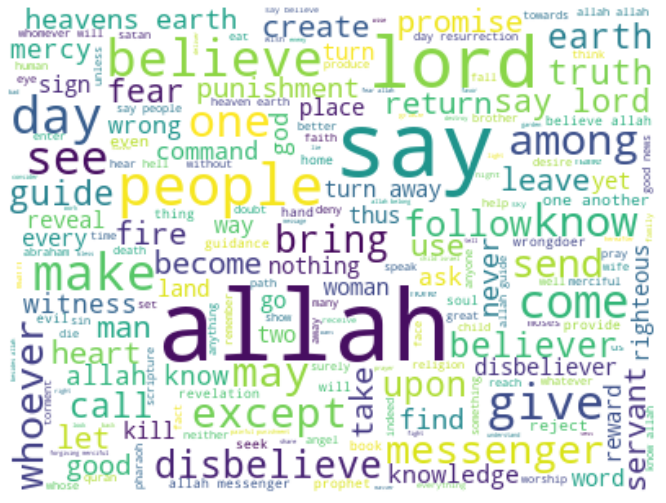

In [151]:
def word_cloud(corpus, wc=WC, method='generate', ind_list=None):
    def get_word_cloud(input_text):
        text = ' '.join(input_text)
        return getattr(wc, method)(text)
        
    if isinstance(corpus[0], list):  
        if ind_list is None:
            ind_list = range(len(corpus))
        n = len(ind_list)
        if n > 10:
            sys.exit(0)
        f, a = plt.subplots(nrows=n, figsize=(8, n * 6))
        for i, ind in enumerate(ind_list):
            wordcloud = get_word_cloud(corpus[ind])
            a[i].imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        f, ax = plt.subplots(figsize=(12, 9))
        wordcloud = get_word_cloud(corpus)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        
# Sample by 10 and plot word cloud
word_cloud([' '.join(doc) for ind, doc in enumerate(processed)]) # if ind % 5 == 0])


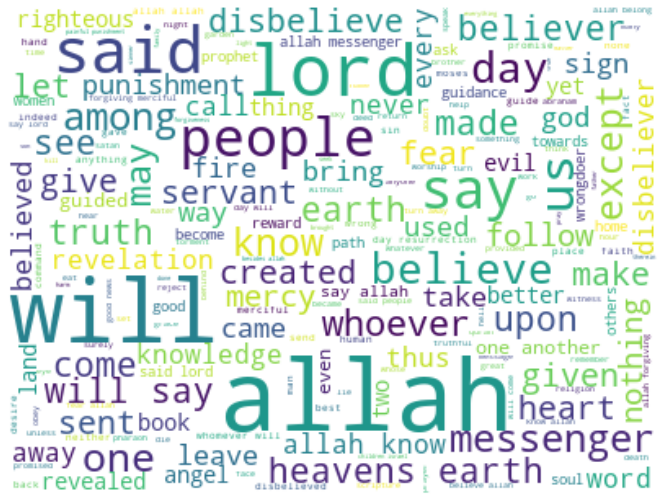

In [152]:
word_cloud(docs)

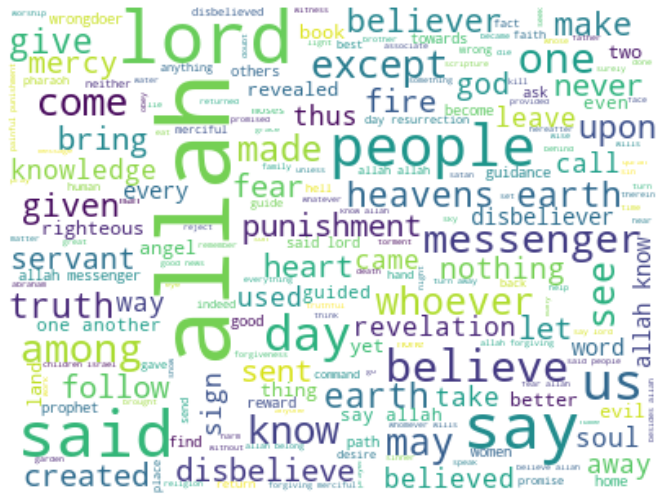

In [153]:
# after parsing
word_cloud([' '.join(ii) for ii in tokens])

### Word cloud by word freq (topic, tfidf, etc.)

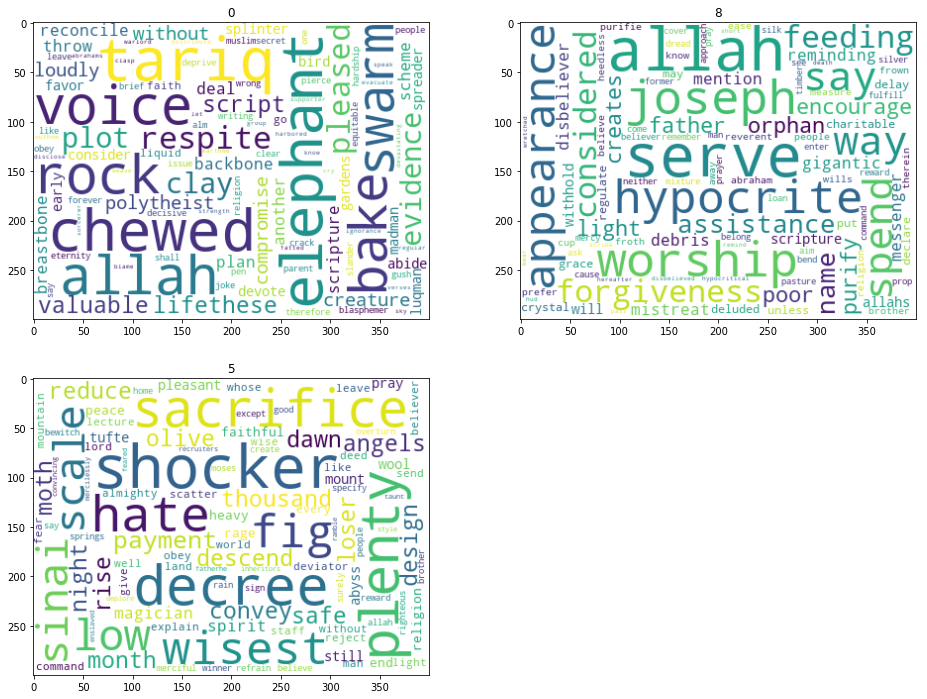

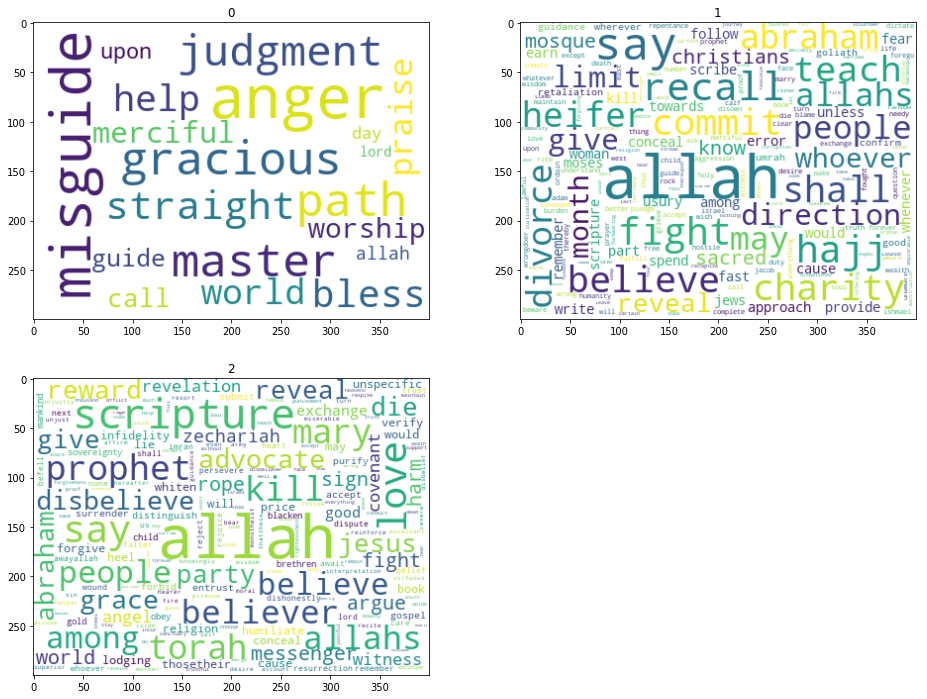

In [156]:
topics_for_wordcloud = lda_selected.show_topics(3, num_words=100, formatted=False)
# TFIDF: Get terms from the dictionary and pair with weights
corpus_ind_list = [0, 1, 2]
corpus_tfidf_by_word = [(ind, [(dictionary[pair[0]], pair[1]) for pair in corpus_tfidf[ind]]) for ind in corpus_ind_list]

def word_cloud_by_freq(a, wc=WC, method='generate_from_frequencies'):  # alias of 'fit_words'
    def get_word_cloud(x):
        return getattr(wc, method)(dict(x))
        
    n = len(a)
    n_rows = int(np.ceil(n / 2))
    if n > 20:
        sys.exit(0)
    f, ax = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, n_rows * 6))
    for i, x in enumerate(a):
        word_freq = x[1]
        wordcloud = get_word_cloud(word_freq)
        axp = ax[i // 2][i % 2]
        axp.imshow(wordcloud, interpolation="bilinear")
        axp.set_title(x[0])
    plt.axis("off")
    plt.show()
    return wordcloud

word_cloud_by_freq(topics_for_wordcloud)
word_cloud_by_freq(corpus_tfidf_by_word)

In [157]:
topics_for_wordcloud

[(0,
  [('tariq', 0.0014040159),
   ('elephant', 0.0013023885),
   ('chewed', 0.0013022947),
   ('allah', 0.0011342531),
   ('voice', 0.001134237),
   ('rock', 0.0011253277),
   ('swarm', 0.0010385285),
   ('bake', 0.00103848),
   ('respite', 0.0010367719),
   ('pleased', 0.000997835),
   ('clay', 0.00085897115),
   ('evidence', 0.00085317576),
   ('plot', 0.0008356794),
   ('lifethese', 0.00083468284),
   ('script', 0.0008346366),
   ('valuable', 0.0008346275),
   ('polytheist', 0.00082790677),
   ('creature', 0.0008229811),
   ('without', 0.0007964519),
   ('compromise', 0.0007951251),
   ('loudly', 0.00079154305),
   ('reconcile', 0.00078544125),
   ('scripture', 0.00078472996),
   ('backbone', 0.000784074),
   ('throw', 0.0007840666),
   ('breastbone', 0.0007840112),
   ('deal', 0.00075348467),
   ('plan', 0.0007515977),
   ('scheme', 0.0007449863),
   ('another', 0.00074448565),
   ('splinter', 0.0007364266),
   ('consider', 0.00072181865),
   ('abide', 0.00072000374),
   ('spread